# Capstone Project: The Battle of Neighborhoods - SG Edition

### 1. Introduction

In Singapore, food courts popular dining option for the locals. They consist of a number of food stalls operating in the same premise, and offer affordable everyday meals.

There are several key food courts operators in the market such as Koufu, Food Republic and Kopitiam. They operate as a chain for efficiency and cost effectiveness, but many of the food courts are similar and not well differentiated.

The Timbre Group is a relatively new entrant in the food court scene. It started off with bistros and restaurants business, and later on ventured into the food court market with its first food court Timbre+, which has a more modern and hip vibe as compared to other food courts. Timbre+ is located in Ayer Rajah neighbourhood, which is in postal district 05 in Singapore.

Suppose Timbre Group would like to replicate its modern food court concept, and they would like to find suitable neighbourhood for their second food court.

The ideal locations for the new food court should be neighbourhoods with other food and beverage venues (which is indicative of good foot fall) but have fewer food court businesses.

### 2. Data

1. List of Singapore postal districts/ neighbouhoods from https://en.wikipedia.org/wiki/Postal_codes_in_Singapore.

2. Geographical coordinates of each neighborhood (in excel format)

3. Venue information from Foursquare API

### 3. Methodology

Import the necessary libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### 3.1 Fetch data on postal districts in Singapore

Fetch the list of postal districts in Singapore from Wikipedia using BeautifulSoup package.

In [2]:
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/Postal_codes_in_Singapore'

html_doc = requests.get(url).text
soup = BeautifulSoup(html_doc, 'html.parser')

tr_list = soup.find('table', class_='wikitable').find_all('tr')
len(tr_list)

29

Create the dataframe for postal districts.

In [3]:
column_names = ['PostalDist', 'PostalSector', 'Neighborhood']
df = pd.DataFrame(columns=column_names)

for tr in tr_list[1:]:
    td_list = [td for td in tr.contents if td != '\n']
    
    postal_dist = td_list[0].text.replace('\n', '')
    postal_sector = td_list[1].text.replace('\n', '')
    neig = td_list[2].text.replace('\n', '')
    
    df = df.append({'PostalDist': postal_dist,
               'PostalSector': postal_sector,
               'Neighborhood': neig
              }
              ,ignore_index=True
             )
    
df.head()

,PostalDist,PostalSector,Neighborhood
0,01,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park"
1,02,"07, 08","Anson, Tanjong Pagar"
2,03,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru"
3,04,"09, 10","Telok Blangah, Harbourfront"
4,05,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New..."


In [4]:
df.shape

(28, 3)

In [5]:
df.dtypes

PostalDist      object
PostalSector    object
Neighborhood    object
dtype: object

Since PostalDist is an object, let's change it to integer.

In [6]:
df['PostalDist'] = df['PostalDist'].astype(int)

In [7]:
df.dtypes

PostalDist       int64
PostalSector    object
Neighborhood    object
dtype: object

In [8]:
df.head()

,PostalDist,PostalSector,Neighborhood
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park"
1,2,"07, 08","Anson, Tanjong Pagar"
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru"
3,4,"09, 10","Telok Blangah, Harbourfront"
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New..."


### 3.2 Get geographical data of postal districts

Load geographical data.

In [9]:
# The code was removed by Watson Studio for sharing.

,Postcode,Latitude,Longitude
0,1,1.279114,103.851259
1,2,1.276904,103.843854
2,3,1.306456,103.794766
3,4,1.279457,103.817898
4,5,1.285272,103.779117


In [10]:
geo_df.dtypes

Postcode       int64
Latitude     float64
Longitude    float64
dtype: object

In [11]:
geo_df.rename(columns={'Postcode': 'PostalDist'}, inplace=True)

sg_df = pd.merge(df, geo_df, on='PostalDist')
sg_df.head()

,PostalDist,PostalSector,Neighborhood,Latitude,Longitude
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259
1,2,"07, 08","Anson, Tanjong Pagar",1.276904,103.843854
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",1.306456,103.794766
3,4,"09, 10","Telok Blangah, Harbourfront",1.279457,103.817898
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",1.285272,103.779117


The geographical coordinates of Singapore is 1.290270, 103.851959.
Let's use it to create a map of Singapore.

In [12]:
latitude = 1.290270
longitude = 103.851959

# create map of Singapore using latitude and longitude values
map_sg = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(sg_df['Latitude'], sg_df['Longitude'], sg_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sg)  
    
map_sg

### 3.3. Fetch data from Foursquare API

First, define Foursquare credentials (hidden cell).

In [13]:
# The code was removed by Watson Studio for sharing.

Explore top 100 venues in each neighborhood within 1000m radius.

In [60]:
LIMIT = 100
radius = 1000

In [61]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [62]:
sg_venues = getNearbyVenues(names=sg_df['Neighborhood'],
                                   latitudes=sg_df['Latitude'],
                                   longitudes=sg_df['Longitude']
                                  )

Raffles Place, Cecil, Marina, People's Park
Anson, Tanjong Pagar
Bukit Merah, Queenstown, Tiong Bahru
Telok Blangah, Harbourfront
Pasir Panjang, Hong Leong Garden, Clementi New Town
High Street, Beach Road (part)
Middle Road, Golden Mile
Little India, Farrer Park, Jalan Besar, Lavender
Orchard, Cairnhill, River Valley
Ardmore, Bukit Timah, Holland Road, Tanglin
Watten Estate, Novena, Thomson
Balestier, Toa Payoh, Serangoon
Macpherson, Braddell
Geylang, Eunos
Katong, Joo Chiat, Amber Road
Bedok, Upper East Coast, Eastwood, Kew Drive
Loyang, Changi
Simei, Tampines, Pasir Ris
Serangoon Garden, Hougang, Punggol
Bishan, Ang Mo Kio
Upper Bukit Timah, Clementi Park, Ulu Pandan
Jurong, Tuas
Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang
Lim Chu Kang, Tengah
Kranji, Woodgrove, Woodlands
Upper Thomson, Springleaf
Yishun, Sembawang
Seletar


In [63]:
print(sg_venues.shape)
sg_venues.head()

(1823, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,Pure Fitness,1.278631,103.851487,Gym
1,"Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,The Westin Singapore,1.278275,103.850772,Hotel
2,"Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,Lau Pa Sat Satay Street,1.280261,103.850235,Street Food Gathering
3,"Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,Sofitel So Singapore,1.280124,103.849867,Hotel
4,"Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,Lobby Lounge Westin,1.277811,103.850966,Bar


In [64]:
sg_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Anson, Tanjong Pagar",100,100,100,100,100,100
"Ardmore, Bukit Timah, Holland Road, Tanglin",71,71,71,71,71,71
"Balestier, Toa Payoh, Serangoon",90,90,90,90,90,90
"Bedok, Upper East Coast, Eastwood, Kew Drive",100,100,100,100,100,100
"Bishan, Ang Mo Kio",72,72,72,72,72,72
"Bukit Merah, Queenstown, Tiong Bahru",100,100,100,100,100,100
"Geylang, Eunos",81,81,81,81,81,81
"High Street, Beach Road (part)",100,100,100,100,100,100
"Hillview, Dairy Farm, Bukit Panjang, Choa Chu Kang",46,46,46,46,46,46


In [65]:
print('There are {} uniques categories.'.format(len(sg_venues['Venue Category'].unique())))

There are 239 uniques categories.


Use onehot key to segregate the venue categories into columns.

In [66]:
sg_onehot = pd.get_dummies(sg_venues[['Venue Category']], prefix="", prefix_sep="")

sg_onehot['Neighborhood'] = sg_venues['Neighborhood']

fixed_columns = [sg_onehot.columns[-1]] + list(sg_onehot.columns[:-1])
sg_onehot = sg_onehot[fixed_columns]

sg_onehot.head()

,Yoga Studio,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Trail,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Canal,Cantonese Restaurant,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dumpling Restaurant,Electronics Store,Event Space,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Store,Flower Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,High School,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lighthouse,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Neighborhood,Nightclub,Noodle House,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Pakistani Restaurant,Park,Peking Duck Restaurant,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Pub,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swim School,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Track,Trail,Transportation Service,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"Raffles Place, Cecil, Marina, People's Park",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [67]:
sg_onehot.shape

(1823, 239)

In [68]:
sg_grouped = sg_onehot.groupby('Neighborhood').mean().reset_index()
sg_grouped

,Neighborhood,Yoga Studio,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Australian Restaurant,BBQ Joint,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Bike Trail,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Bowling Green,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cable Car,Cafeteria,Café,Canal,Cantonese Restaurant,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Clothing Store,Club House,Cocktail Bar,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dumpling Restaurant,Electronics Store,Event Space,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fishing Store,Flower Shop,Food,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Hainan Restaurant,Hakka Restaurant,Halal Restaurant,Harbor / Marina,High School,History Museum,Hobby Shop,Hong Kong Restaurant,Hookah Bar,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Theater,Indonesian Restaurant,Indoor Play Area,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lighthouse,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Military Base,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Monument / Landmark,Mountain,Movie Theater,Moving Target,Multiplex,Museum,Music Store,Music Venue,Nature Preserve,Nightclub,Noodle House,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Pakistani Restaurant,Park,Peking Duck Restaurant,Performing Arts Venue,Pet Café,Pet Store,Pharmacy,Photography Studio,Pier,Pizza Place,Playground,Plaza,Pool,Pool Hall,Port,Pub,Ramen Restaurant,Recreation Center,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Street Food Gathering,Supermarket,Sushi Restaurant,Swim School,Taiwanese Restaurant,Tapas Restaurant,Tea Room,Tech Startup,Temple,Tennis Court,Thai Restaurant,Theater,Theme Park,Thrift / Vintage Store,Track,Trail,Transportation Service,Udon Restaurant,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,"Anson, Tanjong Pagar",0.01,0.000000,0.000000,0.01,0.000000,0.000000,0.020000,0.000000,0.020000,0.010000,0.000000,0.01,0.060000,0.000000,0.020000,0.000000,0.000000,0.000000,0.00,0.020000,0.010000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.01,0.000000,0.000000,0.010000,0.01,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.060000,0.00,0.000000,0.00,0.000000,0.010000,0.000000,0.000000,0.050000,0.080000,0.00,0.00,0.000000,0.000000,0.000000,0.01,0.000000,0.020000,0.000000,0.000000,0.010000,0.000000,0.01,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0

In [69]:
sg_grouped.shape

(28, 239)

### 3.4. Explore top 10 common venues in each neighborhood

Create dataframe to show top 10 common venues in each neighborhood.

In [70]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [71]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = sg_grouped['Neighborhood']

for ind in np.arange(sg_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sg_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Anson, Tanjong Pagar",Japanese Restaurant,Coffee Shop,Bakery,Café,Hotel,Cocktail Bar,Ramen Restaurant,Tapas Restaurant,Italian Restaurant,Korean Restaurant
1,"Ardmore, Bukit Timah, Holland Road, Tanglin",Café,Chinese Restaurant,Seafood Restaurant,Bar,Lounge,Gastropub,Lake,Thai Restaurant,French Restaurant,Indian Restaurant
2,"Balestier, Toa Payoh, Serangoon",Chinese Restaurant,Coffee Shop,Noodle House,Seafood Restaurant,Food Court,Bakery,Fast Food Restaurant,Asian Restaurant,Snack Place,Café
3,"Bedok, Upper East Coast, Eastwood, Kew Drive",Food Court,Coffee Shop,Chinese Restaurant,Bus Stop,Noodle House,Sandwich Place,Indian Restaurant,Asian Restaurant,Café,Bakery
4,"Bishan, Ang Mo Kio",Chinese Restaurant,Food Court,Fast Food Restaurant,Dessert Shop,Japanese Restaurant,Bus Station,Bubble Tea Shop,Park,Coffee Shop,Gym


### 3.5 Cluster the neighborhoods

To cluster the neighborhoods using k-means clustering, let's use the elbow method to identify the optimal k.

In [73]:
sg_grouped_clustering = sg_grouped.drop('Neighborhood', 1)

In [74]:
inertias = [] 
K = range(1,15) 

for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(sg_grouped_clustering)
    inertias.append(km.inertia_)

inertias

[1.3461956887678077,
 0.854309143188843,
 0.7177340148708964,
 0.5893976162758272,
 0.5020485312520897,
 0.46041338455976943,
 0.4062432333280453,
 0.3647905590146794,
 0.32528817462079324,
 0.2887299870115667,
 0.256251109863868,
 0.23000919608559903,
 0.20156967784404733,
 0.17553736135118936]

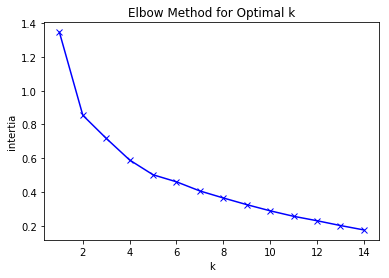

In [75]:
import matplotlib.pyplot as plt 

plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('intertia')
plt.title('Elbow Method for Optimal k')
plt.show()

Based on the plot, k = 5 is the "elbow" point after which the inertia starts decreasing in a linear fashion. As such, we will based on k-means clustering model using k=6.

In [76]:
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sg_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:28]

array([4, 1, 1, 1, 1, 1, 1, 4, 0, 0, 1, 0, 3, 4, 2, 1, 4, 4, 1, 4, 1, 1,
       0, 1, 1, 1, 1, 1], dtype=int32)

In [77]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

sg_merged = sg_df
sg_merged = sg_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
sg_merged.head()

,PostalDist,PostalSector,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"01, 02, 03, 04, 05, 06","Raffles Place, Cecil, Marina, People's Park",1.279114,103.851259,4,Coffee Shop,Hotel,Café,Japanese Restaurant,Korean Restaurant,Gym / Fitness Center,Cocktail Bar,Restaurant,Waterfront,Food Court
1,2,"07, 08","Anson, Tanjong Pagar",1.276904,103.843854,4,Japanese Restaurant,Coffee Shop,Bakery,Café,Hotel,Cocktail Bar,Ramen Restaurant,Tapas Restaurant,Italian Restaurant,Korean Restaurant
2,3,"14, 15, 16","Bukit Merah, Queenstown, Tiong Bahru",1.306456,103.794766,1,Chinese Restaurant,Bakery,Indian Restaurant,Food Court,Japanese Restaurant,Coffee Shop,Café,Salad Place,Italian Restaurant,Ice Cream Shop
3,4,"09, 10","Telok Blangah, Harbourfront",1.279457,103.817898,1,Chinese Restaurant,Food Court,Coffee Shop,Café,Scenic Lookout,Trail,Park,Fast Food Restaurant,Noodle House,Pool
4,5,"11, 12, 13","Pasir Panjang, Hong Leong Garden, Clementi New...",1.285272,103.779117,1,Café,Asian Restaurant,Bar,Port,Kebab Restaurant,Bus Station,Miscellaneous Shop,Food Court,Pier,Metro Station


Visualise the results.

In [78]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sg_merged['Latitude'], sg_merged['Longitude'], sg_merged['Neighborhood'], sg_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Results

Cluster 1

In [79]:
sg_merged.loc[sg_merged['Cluster Labels'] == 0, sg_merged.columns[[0]+[2] + list(range(5, sg_merged.shape[1]))]]

,PostalDist,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
17,18,"Simei, Tampines, Pasir Ris",0,Coffee Shop,Supermarket,Food Court,Seafood Restaurant,Bus Line,Convenience Store,Asian Restaurant,Gym / Fitness Center,Café,General Entertainment
21,22,"Jurong, Tuas",0,Coffee Shop,Malay Restaurant,Food Court,Bus Stop,Supermarket,Cafeteria,Café,Grocery Store,Tech Startup,Park
22,23,"Hillview, Dairy Farm, Bukit Panjang, Choa Chu ...",0,Coffee Shop,Food Court,Chinese Restaurant,Bus Station,Bus Line,Fast Food Restaurant,Convenience Store,Bowling Alley,Frozen Yogurt Shop,Multiplex
24,25,"Kranji, Woodgrove, Woodlands",0,Food Court,Coffee Shop,Arcade,Park,Soup Place,Asian Restaurant,Bus Station,Women's Store,French Restaurant,Food


Cluster 2

In [80]:
sg_merged.loc[sg_merged['Cluster Labels'] == 1, sg_merged.columns[[0]+[2] + list(range(5, sg_merged.shape[1]))]]

,PostalDist,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,3,"Bukit Merah, Queenstown, Tiong Bahru",1,Chinese Restaurant,Bakery,Indian Restaurant,Food Court,Japanese Restaurant,Coffee Shop,Café,Salad Place,Italian Restaurant,Ice Cream Shop
3,4,"Telok Blangah, Harbourfront",1,Chinese Restaurant,Food Court,Coffee Shop,Café,Scenic Lookout,Trail,Park,Fast Food Restaurant,Noodle House,Pool
4,5,"Pasir Panjang, Hong Leong Garden, Clementi New...",1,Café,Asian Restaurant,Bar,Port,Kebab Restaurant,Bus Station,Miscellaneous Shop,Food Court,Pier,Metro Station
9,10,"Ardmore, Bukit Timah, Holland Road, Tanglin",1,Café,Chinese Restaurant,Seafood Restaurant,Bar,Lounge,Gastropub,Lake,Thai Restaurant,French Restaurant,Indian Restaurant
10,11,"Watten Estate, Novena, Thomson",1,Italian Restaurant,Pool,Chinese Restaurant,Bakery,Restaurant,Japanese Restaurant,Gym,Nightclub,Tennis Court,Seafood Restaurant
11,12,"Balestier, Toa Payoh, Serangoon",1,Chinese Restaurant,Coffee Shop,Noodle House,Seafood Restaurant,Food Court,Bakery,Fast Food Restaurant,Asian Restaurant,Snack Place,Café
12,13,"Macpherson, Braddell",1,Coffee Shop,Chinese Restaurant,Food Court,Bus Station,Convenience Store,Gym,Restaurant,Indian Restaurant,Fast Food Restaurant,Café
13,14,"Geylang, Eunos",1,Coffee Shop,Chinese Restaurant,Hotel,Indian Restaurant,Food Court,Noodle House,Supermarket,BBQ Joint,Café,Dim Sum Restaurant
14,15,"Katong, Joo Chiat, Amber Road",1,Asian Restaurant,Noodle House,Chinese Restaurant,Coffee Shop,Food Court,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Supermarket,Snack Place
15,16,"Bedok, Upper East Coast, Eastwood, Kew Drive",1,Food Court,Coffee Shop,Chinese Restaurant,Bus Stop,Noodle House,Sandwich Place,Indian Restaurant,Asian Restaurant,Café,Bakery


Cluster 3

In [81]:
sg_merged.loc[sg_merged['Cluster Labels'] == 2, sg_merged.columns[[0]+[2] + list(range(5, sg_merged.shape[1]))]]

,PostalDist,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,17,"Loyang, Changi",2,Military Base,Gym,Women's Store,Garden Center,Gaming Cafe,Furniture / Home Store,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant


Cluster 4

In [82]:
sg_merged.loc[sg_merged['Cluster Labels'] == 3, sg_merged.columns[[0]+[2] + list(range(5, sg_merged.shape[1]))]]

,PostalDist,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
23,24,"Lim Chu Kang, Tengah",3,Farm,Flower Shop,Pet Store,Garden,Café,Farmers Market,Garden Center,Coffee Shop,Spa,Fried Chicken Joint


Cluster 5

In [83]:
sg_merged.loc[sg_merged['Cluster Labels'] == 4, sg_merged.columns[[0]+[2] + list(range(5, sg_merged.shape[1]))]]

,PostalDist,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,"Raffles Place, Cecil, Marina, People's Park",4,Coffee Shop,Hotel,Café,Japanese Restaurant,Korean Restaurant,Gym / Fitness Center,Cocktail Bar,Restaurant,Waterfront,Food Court
1,2,"Anson, Tanjong Pagar",4,Japanese Restaurant,Coffee Shop,Bakery,Café,Hotel,Cocktail Bar,Ramen Restaurant,Tapas Restaurant,Italian Restaurant,Korean Restaurant
5,6,"High Street, Beach Road (part)",4,Hotel,Japanese Restaurant,Cocktail Bar,Café,Italian Restaurant,Coffee Shop,Concert Hall,Waterfront,Supermarket,Gym / Fitness Center
6,7,"Middle Road, Golden Mile",4,Café,Indian Restaurant,Hotel,Bakery,Vegetarian / Vegan Restaurant,Arts & Crafts Store,Japanese Restaurant,Shopping Mall,Whisky Bar,Coffee Shop
7,8,"Little India, Farrer Park, Jalan Besar, Lavender",4,Indian Restaurant,Chinese Restaurant,Café,Hotel,Bakery,Coffee Shop,Restaurant,Vietnamese Restaurant,Hostel,Indonesian Restaurant
8,9,"Orchard, Cairnhill, River Valley",4,Hotel,Café,Japanese Restaurant,Coffee Shop,Art Gallery,Arts & Crafts Store,Sushi Restaurant,French Restaurant,Movie Theater,Clothing Store


Using Foursquare API, I can obtain data of common places in Singapore to:

* Identify the similarity or dissimilarity of different neighbourhoods
* Cluster the neighbourhoods based on commonality

I can then use such analysis as one of my input to assess areas which may have good potential for new business in addition to other market and financial data.